In [379]:
from topological_labyrinths_rl.envs.library_3x3 import LIBRARY_3X3_LABYRINTHS
import gym
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

env = gym.make("topological-labyrinths-2D-v0", envs_library=LIBRARY_3X3_LABYRINTHS, pi=0, draw_deterministic=5)

Text(0.5, 1.0, 'State Distributions ($s_1$, $s_2$, $s_3$, $s_4$)')

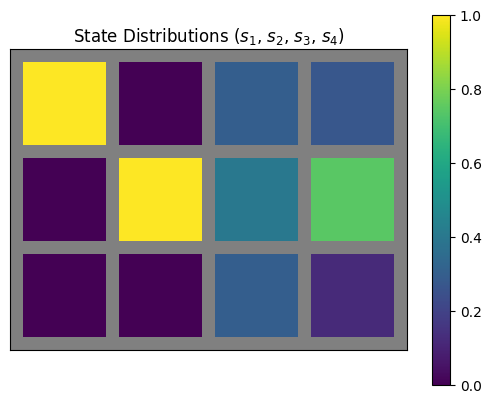

In [380]:
p_a1 = np.array([[0, 0.3, 0.5],
                 [1, 0.4, 0.95],
                 [0, 0.3, 0]])
rho_0 = np.array([[1], [0], [0]])
ph0_t = np.concatenate([rho_0, p_a1 @ rho_0, p_a1 @ p_a1 @ rho_0, p_a1 @ p_a1 @ p_a1 @ rho_0], axis=1)

_, ax = plt.subplots(1, 1)
cbar = plot_state_function(ph0_t, adjacency=np.zeros([12, 12]), ax=ax, cmap="viridis")
plt.colorbar(cbar)
plt.title(r"State Distributions ($s_1$, $s_2$, $s_3$, $s_4$)")

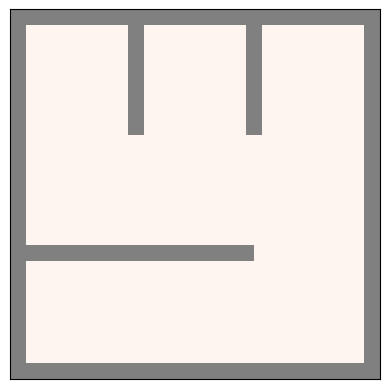

In [381]:
def plot_state_function(func, adjacency, n_tiles_per_state=15, ax=None, cmap="Reds"):
    n = n_tiles_per_state
    single_state_tiles = np.arange(n*n).reshape(n, n)
    i, j = func.shape
    
    total_mask = np.pad(np.zeros([n*i, n*j]) != 0, 1, constant_values=True)
    
    for state in range(i*j):
        mask = np.zeros([n, n]) != 0
        if not ((state % j != 0) and adjacency[state, state - 1]): 
            mask = mask | (single_state_tiles % n == 0)
                    
        if not ((state <= (i*j - j - 1)) and adjacency[state, state + j]):
            mask = mask | (single_state_tiles > (n*n - n - 1))
                
        if not ((state % j < (j-1)) and adjacency[state, state + 1]):
            mask = mask | (single_state_tiles % n == (n-1))
                
        if not ((state >= j) and adjacency[state, state - j]):
            mask = mask | (single_state_tiles < n)

        x = state // j
        y = state % j
        
        total_mask[1+n*x:1+n*x+n, 1+n*y:1+n*y+n] = mask
    
    func_enlarged = np.pad(np.repeat(np.repeat(func, n, axis=0), n, axis=1), 1, mode="edge")
    
    masked_func = np.ma.masked_where(total_mask, func_enlarged)
        
    pcm = ax.imshow(masked_func, cmap=cmap)
    
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
    ax.set_facecolor('grey')
    
    return pcm

def draw_maze(i, j, adjacency, ax):
    return plot_state_function(np.ones([i, j]), adjacency, ax=ax)

_, ax = plt.subplots(1, 1)
draw_maze(3, 3, env.current_graph_adjacency, ax)

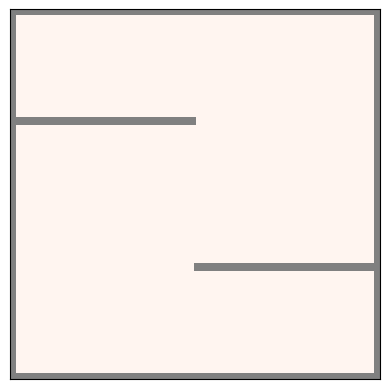

In [382]:
i, j = 10, 10
g = nx.grid_2d_graph(i, j)
A = nx.to_numpy_array(g)
for a in range(20, 25):
    A[a, a + j] = 0
    A[a + j, a] = 0
for a in range(65, 70):
    A[a, a + j] = 0
    A[a + j, a] = 0

_, ax = plt.subplots(1, 1)
draw_maze(i, j, A, ax=ax)

Text(0.5, 1.0, 'C(s=33)')

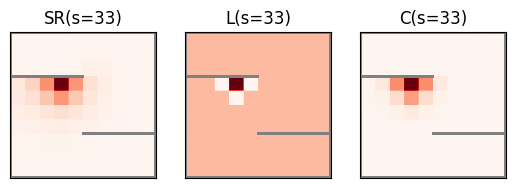

In [395]:
import scipy
def eigen_resolvent(sorted_lambdas):
    gamma = 0.85/sorted_lambdas[-1]  # convention is gamma=0.85/lambda_max
    return np.diag(1/(1-gamma*sorted_lambdas))


def compute_communicability(eigenvalues, eigenvectors, time):
    x = eigenvalues
    return eigenvectors @ np.diag(np.exp(-x*time)) @ eigenvectors.conj().T

adjacency = A
plot_state = 33
gamma = 0.85

degree_vector = np.sum(adjacency, axis=0)
degree_matrix = np.diag(degree_vector)
delta = np.diag(1/np.sqrt(degree_vector))
markov = delta @ adjacency @ delta
markov_2 = np.linalg.inv(degree_matrix) @ adjacency

sr = np.linalg.inv(np.eye(markov.shape[1]) - gamma*markov)

eigenValues, eigenVectors = scipy.linalg.eig(laplacian)

_, ax = plt.subplots(1, 3)
pcm = plot_state_function(sr[:,plot_state].reshape(i, j), adjacency, ax=ax[0])
ax[0].set_title(f"SR(s={plot_state})")

laplacian = degree_matrix - adjacency

pcm = plot_state_function(laplacian[:,plot_state].reshape(i, j), adjacency, ax=ax[1])

c = compute_communicability(eigenValues, eigenVectors, gamma/2)
ax[1].set_title(f"L(s={plot_state})")

pcm = plot_state_function(abs(c[:,plot_state].reshape(i, j)), adjacency, ax=ax[2])
ax[2].set_title(f"C(s={plot_state})")

Text(0.5, 1.0, '$V_{g_3}(s)$')

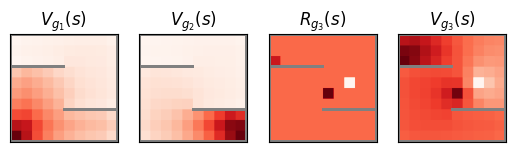

In [405]:
goal_1 = np.zeros(i*j)
goal_2 = goal_1.copy()
goal_3 = goal_1.copy()

goal_1[90] = 1
goal_2[99] = 1
goal_3[47] = -10
goal_3[55] = 10
goal_3[20] = 5


_, ax = plt.subplots(1, 4)

sr_big_gamma = np.linalg.inv(np.eye(markov.shape[1]) - 0.99*markov)

pcm = plot_state_function((sr_big_gamma @ goal_1).reshape(i, j), adjacency, ax=ax[0])
ax[0].set_title(r"$V_{g_1}(s)$")

pcm = plot_state_function((sr_big_gamma @ goal_2).reshape(i, j), adjacency, ax=ax[1])
ax[1].set_title(r"$V_{g_2}(s)$")

pcm = plot_state_function(goal_3.reshape(i, j), adjacency, ax=ax[2])
ax[2].set_title(r"$R_{g_3}(s)$")

pcm = plot_state_function((sr_big_gamma @ goal_3).reshape(i, j), adjacency, ax=ax[3])
ax[3].set_title(r"$V_{g_3}(s)$")

In [345]:
eigenValues, eigenVectors, _ = scipy.linalg.eig(laplacian, left=True)
idx = eigenValues.argsort()[::1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

fig, axs = plt.subplots(i//2, j//2, figsize=(100, 100))

for v, ax in enumerate(axs.flatten()):
    pcm = plot_state_function(eigenVectors[:,v].reshape(i, j), adjacency, ax=ax)
    ax.set_title(f"Eigenvektor {v+1}")

plt.colorbar(pcm, ax=axs.ravel().tolist())

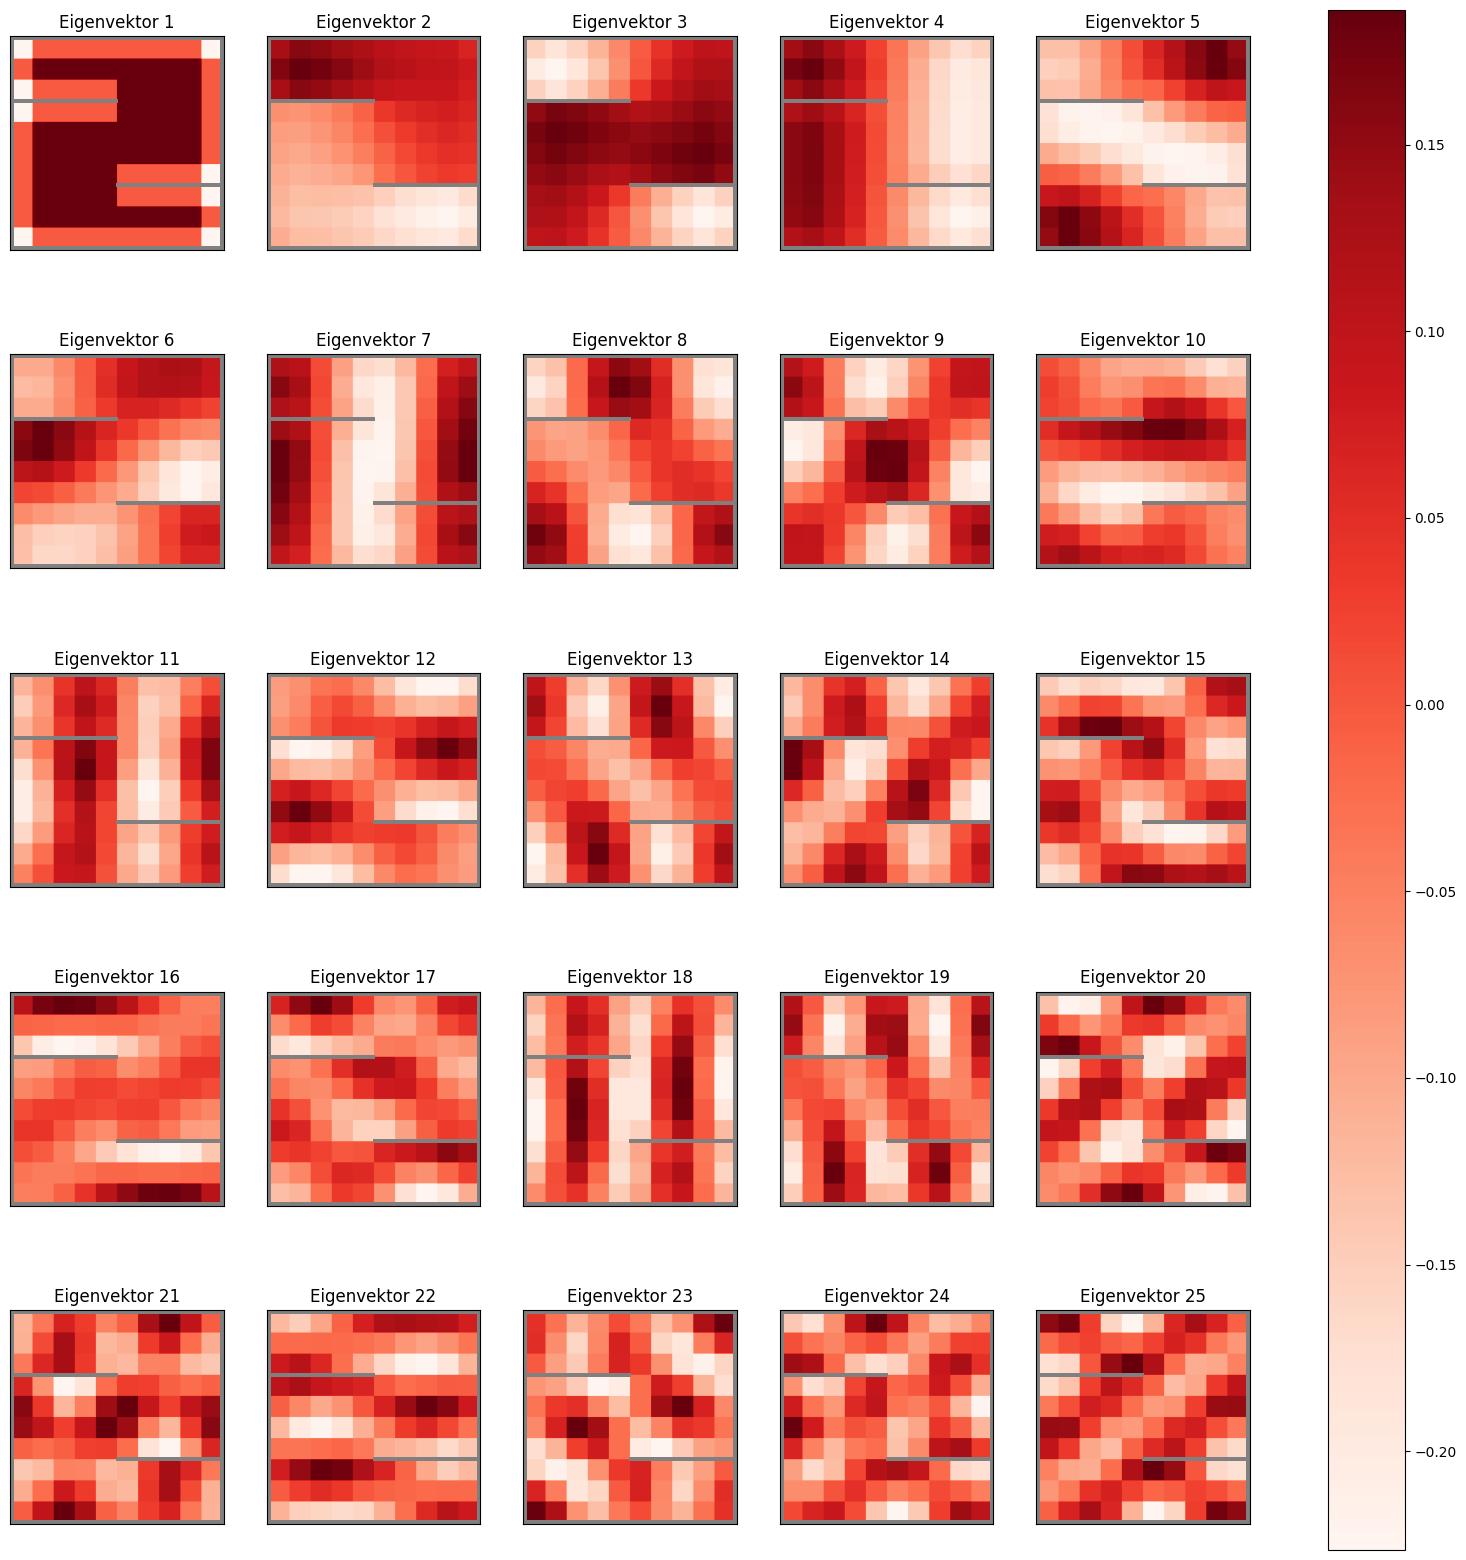

In [347]:
eigenValues, eigenVectors, _ = scipy.linalg.eig(sr, left=True)
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

fig, axs = plt.subplots(i//2, j//2, figsize=(20, 20))

for v, ax in enumerate(axs.flatten()):
    pcm = plot_state_function(eigenVectors[:,v].reshape(i, j), adjacency, ax=ax)
    ax.set_title(f"Eigenvektor {v+1}")

plt.colorbar(pcm, ax=axs.ravel().tolist())

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


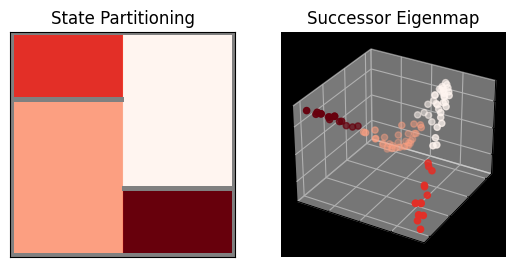

In [406]:
adjacency = A

degree_vector = np.sum(adjacency, axis=0)
degree_matrix = np.diag(degree_vector)
delta = np.diag(1/np.sqrt(degree_vector))
markov = delta @ adjacency @ delta

sr = np.linalg.inv(np.eye(markov.shape[1]) - 0.8*markov)

eigenValues, eigenVectors, _ = scipy.linalg.eig(sr, left=True)

model = KMeans(n_clusters=4)

classes = model.fit_predict(eigenVectors[:, :4])

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

plot_state_function(classes.reshape(i, j), adjacency, ax=ax1)
ax1.set_title("State Partitioning")

ax2.scatter(eigenVectors[:, 1], eigenVectors[:, 2], eigenVectors[:, 3], c=classes, cmap="Reds")
ax2.set_facecolor('black')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False,
                right=False, labelbottom=False, labelleft=False)
ax2.set_title("Successor Eigenmap")

plt.show()

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


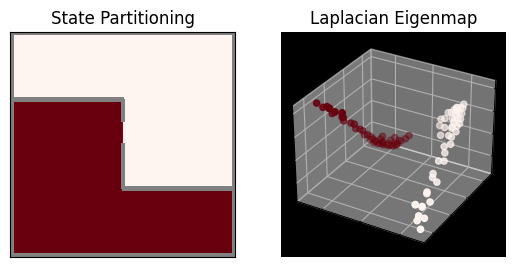

In [362]:
A_bottleneck = A.copy()
A_bottleneck[34, 35] = 0
A_bottleneck[54, 55] = 0
A_bottleneck[64, 65] = 0

A_bottleneck[35, 34] = 0
A_bottleneck[55, 54] = 0
A_bottleneck[65, 64] = 0

adjacency = A_bottleneck

degree_vector = np.sum(adjacency, axis=0)
degree_matrix = np.diag(degree_vector)
delta = np.diag(1/np.sqrt(degree_vector))
markov = delta @ adjacency @ delta

sr = np.linalg.inv(np.eye(markov.shape[1]) - 0.8*markov)

eigenValues, eigenVectors, _ = scipy.linalg.eig(sr, left=True)

model = KMeans(n_clusters=2)

classes = model.fit_predict(eigenVectors[:, :4])

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

plot_state_function(classes.reshape(i, j), adjacency, ax=ax1)
ax1.set_title("State Partitioning")

ax2.scatter(eigenVectors[:, 1], eigenVectors[:, 2], eigenVectors[:, 3], c=classes, cmap="Reds")
ax2.set_facecolor('black')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False,
                right=False, labelbottom=False, labelleft=False)
ax2.set_title("Laplacian Eigenmap")

plt.show()